In [9]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared, ConstantKernel

import os
import pickle
from time import time
from sklearn.decomposition import PCA


import pdspy.modeling as modeling
import pdspy.dust as dust
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import glob

import lhsmdu #github.com/sahilm89

In [10]:
param_names = ["Tstar","logLstar","logMdisk","logRdisk","h0","logRin",\
          "gamma","beta","logMenv","logRenv","fcav","ksi","logamax","p","incl"]

ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]

steps=[]
bases=[]
for i in range(len(ranges)):
    steps.append(np.linspace(ranges[i][0],ranges[i][1],11))
    bases.append(steps[i][5])
    
# training set - read in filenames and logspace flux values
with open ('../grid_metadata/core78.txt', 'rb') as fp:
    core= pickle.load(fp)
with open ('../grid_metadata/cube78.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))
with open ('../grid_metadata/cube78.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)   

In [11]:
#r=[[3000,5000],[0,3]]
#coords=np.array(lhsmdu.sample(2,100))
#coords=coords*np.array([r[0][1]-r[0][0],r[1][1]-r[1][0]])[:,np.newaxis]
#coords+=np.array([r[0][0],r[1][0]])[:,np.newaxis]

#with open('../grid_metadata/2dgrid_coords.txt', 'wb') as fp:
#    pickle.dump(coords, fp)

#with open ('../grid_metadata/2dgrid_coords.txt', 'rb') as fp:
#    coords = pickle.load(fp)

In [12]:
r=[ranges[2],ranges[3]]
coords=np.array(lhsmdu.sample(2,100))
coords=coords*np.array([r[0][1]-r[0][0],r[1][1]-r[1][0]])[:,np.newaxis]
coords+=np.array([r[0][0],r[1][0]])[:,np.newaxis]

with open('../grid_metadata/23_coords.txt', 'wb') as fp:
    pickle.dump(coords, fp)

with open ('../grid_metadata/23_coords.txt', 'rb') as fp:
    coords = pickle.load(fp)

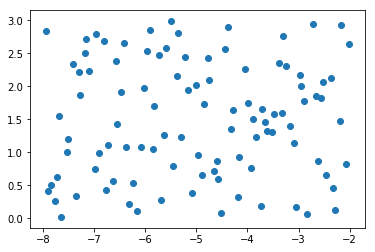

In [13]:
plt.scatter(coords[0],coords[1])

In [19]:
def run_yso_model( Tstar=None, logL_star=None, \
        logM_disk=None, logR_disk=None, h_0=None, logR_in=None, gamma=None, \
        beta=None, logM_env=None, logR_env=None, f_cav=None, ksi=None, \
        loga_max=None, p=None, incl=None):
    
    params = [Tstar,logL_star,logM_disk,logR_disk,h_0,logR_in,\
          gamma,beta,logM_env,logR_env,f_cav,ksi,loga_max,p,incl]

    # Set up the dust properties.

    dust_gen = dust.DustGenerator(dust.__path__[0]+"/data/diana_wice.hdf5")
    ddust = dust_gen(10.**loga_max / 1e4, p)
    env_dust_gen = dust.DustGenerator(dust.__path__[0]+\
            "/data/diana_wice.hdf5")
    edust = env_dust_gen(1.0e-4, 3.5)

    # Calculate alpha correctly.

    alpha = gamma + beta

    # Fix the scale height of the disk.

    h_0 *= (10.**logR_disk)**beta

    # Set up the model.

    model = modeling.YSOModel()
    model.add_star(luminosity=10.**logL_star, temperature=Tstar)
    model.set_spherical_grid(10.**logR_in, 10.**logR_env, 100, 101, 2, \
            code="radmc3d")
    model.add_pringle_disk(mass=10.**logM_disk, rmin=10.**logR_in, \
            rmax=10.**logR_disk, plrho=alpha, h0=h_0, plh=beta, dust=ddust)
    model.add_ulrich_envelope(mass=10.**logM_env, rmin=10.**logR_in, \
            rmax=10.**logR_env, cavpl=ksi, cavrfact=f_cav, dust=edust)
    model.grid.set_wavelength_grid(0.1,1.0e5,500,log=True)
    
    print("finished setting up model, now running thermal simulation")

    # Run the thermal simulation
    model.run_thermal(code="radmc3d", nphot=1e6, \
            modified_random_walk=True, verbose=False, setthreads=17, \
            timelimit=10800)
    
    print("finished running thermal simulation, now running SED")
    t2=time()
    
    # Run the SED.

    model.set_camera_wavelength(np.logspace(-1.,4.,500))
    model.run_sed(name="SED", nphot=1e5, loadlambda=True, incl=incl, \
            pa=0., dpc=140., code="radmc3d", camera_scatsrc_allfreq=True, \
            verbose=False, setthreads=17)
    
    filename=""
    for i in range(len(param_names)):
        filename+=param_names[i]+"_"
        filename+=str(params[i])+"_"
    filename=filename[:-1]
    filename+=".hdf5"
    print("finished running "+filename[0:40]+"... in %0.3fs" % (time() - t2))
    
    # Write out the file.
    model.write_yso("../grid/grid23/"+filename)

In [20]:
pars=bases

In [21]:
for i in range(14,len(coords[0])):
    t0=time()
    run_yso_model(Tstar=pars[0], logL_star=pars[1], \
            logM_disk=coords[0][i], logR_disk=coords[1][i], h_0=pars[4], logR_in=pars[5], gamma=pars[6], \
            beta=pars[7], logM_env=pars[8], logR_env=pars[9], f_cav=pars[10], ksi=pars[11], \
            loga_max=pars[12], p=pars[13], incl=pars[14])
    print("finished running SED #"+str(i)+" in %0.3fs" % (time() - t0))

finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-2.55... in 570.995s
finished running SED #14 in 2492.496s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-7.52... in 231.582s
finished running SED #15 in 239.116s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.58... in 212.212s
finished running SED #16 in 219.354s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-7.84... in 240.149s
finished running SED #17 in 247.816s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
fini

finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-4.18... in 501.772s
finished running SED #51 in 889.055s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-2.66... in 563.863s
finished running SED #52 in 2448.391s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-6.81... in 175.237s
finished running SED #53 in 179.370s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-7.76... in 242.278s
finished running SED #54 in 250.213s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-4.43... i

finished running Tstar_4000.0_logLstar_1.0_logMdisk_-6.56... in 184.905s
finished running SED #88 in 189.840s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-3.24... in 523.000s
finished running SED #89 in 892.530s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-3.08... in 555.728s
finished running SED #90 in 1750.477s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.50... in 190.132s
finished running SED #91 in 195.573s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.62... in 389.061s
finished running SED #92 in 409.471s
finis

In [22]:
r=[ranges[11],ranges[12]]
coords=np.array(lhsmdu.sample(2,100))
coords=coords*np.array([r[0][1]-r[0][0],r[1][1]-r[1][0]])[:,np.newaxis]
coords+=np.array([r[0][0],r[1][0]])[:,np.newaxis]

with open('../grid_metadata/1112_coords.txt', 'wb') as fp:
    pickle.dump(coords, fp)

with open ('../grid_metadata/1112_coords.txt', 'rb') as fp:
    coords = pickle.load(fp)

In [25]:
def run_yso_model( Tstar=None, logL_star=None, \
        logM_disk=None, logR_disk=None, h_0=None, logR_in=None, gamma=None, \
        beta=None, logM_env=None, logR_env=None, f_cav=None, ksi=None, \
        loga_max=None, p=None, incl=None):
    
    params = [Tstar,logL_star,logM_disk,logR_disk,h_0,logR_in,\
          gamma,beta,logM_env,logR_env,f_cav,ksi,loga_max,p,incl]

    # Set up the dust properties.

    dust_gen = dust.DustGenerator(dust.__path__[0]+"/data/diana_wice.hdf5")
    ddust = dust_gen(10.**loga_max / 1e4, p)
    env_dust_gen = dust.DustGenerator(dust.__path__[0]+\
            "/data/diana_wice.hdf5")
    edust = env_dust_gen(1.0e-4, 3.5)

    # Calculate alpha correctly.

    alpha = gamma + beta

    # Fix the scale height of the disk.

    h_0 *= (10.**logR_disk)**beta

    # Set up the model.

    model = modeling.YSOModel()
    model.add_star(luminosity=10.**logL_star, temperature=Tstar)
    model.set_spherical_grid(10.**logR_in, 10.**logR_env, 100, 101, 2, \
            code="radmc3d")
    model.add_pringle_disk(mass=10.**logM_disk, rmin=10.**logR_in, \
            rmax=10.**logR_disk, plrho=alpha, h0=h_0, plh=beta, dust=ddust)
    model.add_ulrich_envelope(mass=10.**logM_env, rmin=10.**logR_in, \
            rmax=10.**logR_env, cavpl=ksi, cavrfact=f_cav, dust=edust)
    model.grid.set_wavelength_grid(0.1,1.0e5,500,log=True)
    
    print("finished setting up model, now running thermal simulation")

    # Run the thermal simulation
    model.run_thermal(code="radmc3d", nphot=1e6, \
            modified_random_walk=True, verbose=False, setthreads=17, \
            timelimit=10800)
    
    print("finished running thermal simulation, now running SED")
    t2=time()
    
    # Run the SED.

    model.set_camera_wavelength(np.logspace(-1.,4.,500))
    model.run_sed(name="SED", nphot=1e5, loadlambda=True, incl=incl, \
            pa=0., dpc=140., code="radmc3d", camera_scatsrc_allfreq=True, \
            verbose=False, setthreads=17)
    
    filename=""
    for i in range(len(param_names)):
        filename+=param_names[i]+"_"
        filename+=str(params[i])+"_"
    filename=filename[:-1]
    filename+=".hdf5"
    print("finished running "+filename[0:40]+"... in %0.3fs" % (time() - t2))
    
    # Write out the file.
    model.write_yso("../grid/grid1112/"+filename)

In [ ]:
for i in range(len(coords[0])):
    t0=time()
    run_yso_model(Tstar=pars[0], logL_star=pars[1], \
            logM_disk=pars[2], logR_disk=pars[3], h_0=pars[4], logR_in=pars[5], gamma=pars[6], \
            beta=pars[7], logM_env=pars[8], logR_env=pars[9], f_cav=pars[10], ksi=coords[0][i], \
            loga_max=coords[1][i], p=pars[13], incl=pars[14])
    print("finished running SED #"+str(i)+" in %0.3fs" % (time() - t0))

finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 432.308s
finished running SED #0 in 457.084s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 419.163s
finished running SED #1 in 442.474s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 389.058s
finished running SED #2 in 407.193s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 410.935s
finished running SED #3 in 498.589s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished 